In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
tf.__version__

'2.4.1'

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import datetime, os
import tqdm
import cv2


from tensorflow.keras.preprocessing import image_dataset_from_directory
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Get datasets

In [9]:
# train_dir = "/content/drive/MyDrive/ML-intern-project/classification-spotphish/spotphish5k/train"
test_dir = "/content/drive/MyDrive/ML-intern-project/classification-spotphish/spotphish5k/test"
#train_dir = "/content/drive/MyDrive/ML-data/test_data_classification"
train_dir = "/content/drive/MyDrive/IITB/spotphish_new"
IMG_SIZE = (224, 224)
train_dataset = image_dataset_from_directory(train_dir, shuffle=True, seed = 123, validation_split = 0.2, subset = "training", image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(train_dir,shuffle=True,seed = 123, validation_split = 0.2, subset = "validation", image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(test_dir,shuffle=True,image_size=IMG_SIZE)
class_names = train_dataset.class_names
num_classes = len(class_names)

class_names = train_dataset.class_names
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
print(tf.data.experimental.cardinality(train_dataset))
print(tf.data.experimental.cardinality(validation_dataset))
print(tf.data.experimental.cardinality(test_dataset))


# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Found 1244 files belonging to 5 classes.
Using 996 files for training.
Found 1244 files belonging to 5 classes.
Using 248 files for validation.
Found 1107 files belonging to 51 classes.
tf.Tensor(32, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(35, shape=(), dtype=int64)


### Get the stats of the files in directories

In [ ]:
print("TRAINING DATA:")
for i in os.listdir(train_dir):
    files = os.listdir(os.path.join(train_dir, i))
    print(f'{i} : {len(files)}')
    
print("\n\nTEST DATA:")
for i in os.listdir(test_dir):
    files = os.listdir(os.path.join(test_dir, i))
    print(f'{i} : {len(files)}')

TRAINING DATA:
dropbox : 212
paypal : 286
facebook : 400
google : 138
amazon : 208


TEST DATA:
hdfc : 24
rblbank : 13
pinterest : 8
bob : 30
ib : 12
groww : 15
sbi : 33
bandhanbank : 10
indusindbank : 58
etrade : 7
ola : 7
linkedin : 37
twitter : 26
axis : 31
facebook : 26
canarabank : 21
psb : 70
incometax : 20
iob : 18
bigbasket : 10
cbi : 11
idfc : 20
kotak : 23
amazon : 21
cdsl : 10
upstox : 49
hsbc : 15
bom : 9
idbibank : 25
icici : 45
dropbox : 22
instagram : 6
zerodha : 16
boi : 9
yesbank : 11
citibank : 13
ikea : 32
flipkart : 11
zomato : 8
uber : 7
nsdl : 28
google : 17
bse : 8
whatsapp : 21
swiggy : 9
paytm : 67
unionbank : 26
pnb : 10
federalbank : 13
paypal : 57
ucobank : 12


In [ ]:
def stats(dir):
    
  images = []
  labels = []

  print("Loading {}".format(dir))

  # Iterate through each folder corresponding to a category
  for folder in os.listdir(dir):
      label = folder
      
      # Iterate through each image in our folder
      for file in os.listdir(os.path.join(dir, folder)):
          # Get the path name of the image
          img_path = os.path.join(os.path.join(dir, folder), file)

          # Append the image and its corresponding label to the output
          images.append(file)
          labels.append(label)
          
  return images, labels

In [ ]:
images, labels = stats(train_dir)

Loading /content/drive/MyDrive/IITB/spotphish_new


In [ ]:
import pandas as pd

_, train_counts = np.unique(labels, return_counts=True)
# _, test_counts = np.unique(test_labels, return_counts=True)
# pd.DataFrame({'train': train_counts,
#                     'test': test_counts}, 
#              index=class_names
#             ).plot.bar()

In [ ]:
pdf = pd.DataFrame({'files':images, 'labels':labels})

In [ ]:
pdf.head(10)

,files,labels
0,dropbox_snap_9.PNG,dropbox
1,dropbox_snap_8.PNG,dropbox
2,dropbox_snap_6.PNG,dropbox
3,dropbox_snap_7.PNG,dropbox
4,dropbox_snap_2.PNG,dropbox
5,dropbox_snap_4.PNG,dropbox
6,dropbox_snap_1.PNG,dropbox
7,dropbox_snap_5.PNG,dropbox
8,dropbox_snap_3.PNG,dropbox
9,dropbox_login_56.png,dropbox


In [ ]:
pdf.groupby('labels').count()

,files
labels,
amazon,208
dropbox,212
facebook,400
google,138
paypal,286


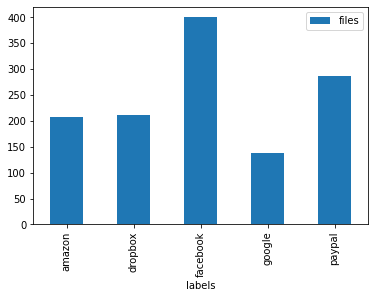

In [ ]:
pdf.groupby('labels').count().plot.bar()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5b0a77a90>],
      dtype=object)

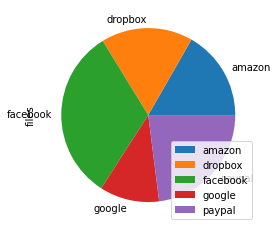

In [ ]:
pdf.groupby('labels').count().plot.pie(subplots=True)

### Visualize the features through PCA. Feature extraction with VGG ImageNet

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [13]:
def load_data():
        
    datasets = [train_dir]    
    images = []
    labels = []
        
    
    # Iterate through training and test sets
    for dataset in datasets:    
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in os.listdir(os.path.join(dataset, folder)):                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMG_SIZE)                 
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')
        
    return images, labels

In [16]:
images, labels = load_data()

Loading /content/drive/MyDrive/IITB/spotphish_new


In [36]:
labels.shape, images.shape

((1244,), (1244, 224, 224, 3))

In [18]:
train_features = model.predict(images)

In [20]:
n_train, x, y, z = train_features.shape
numFeatures = x * y * z

In [22]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)
X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

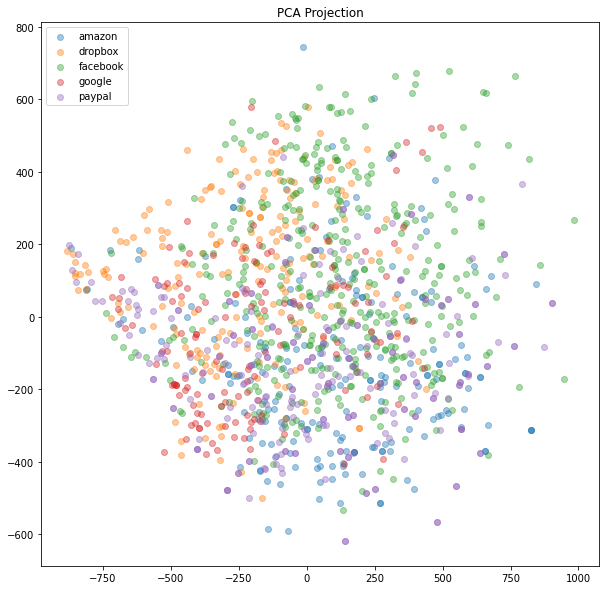

In [23]:
### Figures
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[labels == i][:1000], C2[labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

In [27]:
from sklearn.manifold import TSNE
n_train, x, y, z = train_features.shape
numFeatures = x * y * z
X = train_features.reshape((n_train, x*y*z))
tsne = TSNE(n_components=2).fit_transform(X)

In [41]:
labels == i

array([False, False, False, ..., False, False, False])

In [42]:
tx = tsne[:,0]
ty = tsne[:,1]

tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

C1 = tx
C2 = ty

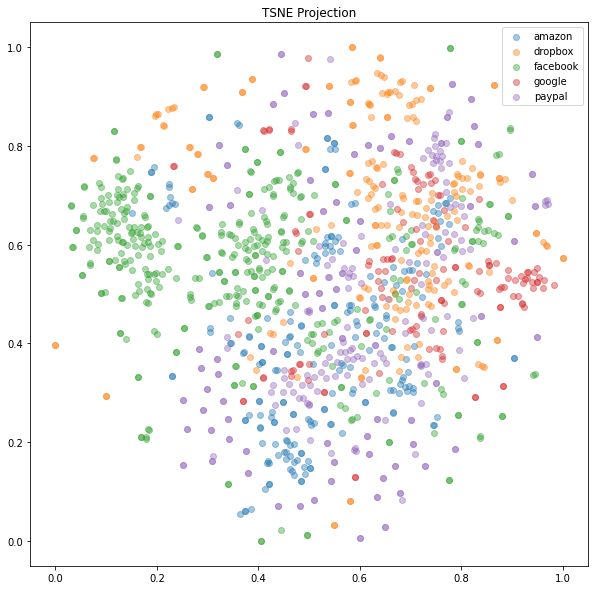

In [44]:
### Figures
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[labels == i][:2000], C2[labels == i][:2000], label = class_name, alpha=0.4)
plt.legend()
plt.title("TSNE Projection")
plt.show()

In [ ]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [28]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

NameError: ignored

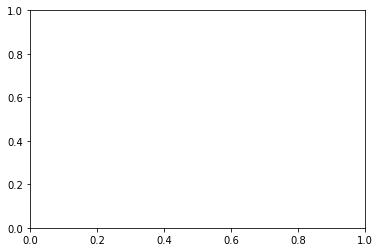

In [29]:
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)

# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format
    color = np.array(colors_per_class[label], dtype=np.float) / 255

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label)

# build a legend using the labels we set previously
ax.legend(loc='best')

# finally, show the plot
plt.show()

In [ ]:
# get the bad images
# import glob
# import imghdr
# dir_list = next(os.walk(train_dir))[1]

# for dir in dir_list:
#   path = os.path.join(train_dir, dir)
#   path = path + "/*"
#   print(path)
#   filenames = [filename for filename in glob.glob(path) if not imghdr.what(filename)]
#   print (filenames)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# #test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

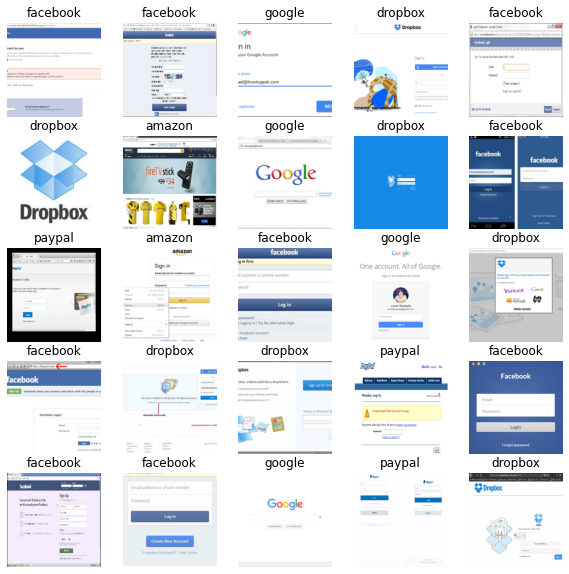

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
image_batch, label_batch = next(iter(train_dataset))

In [ ]:
class_names[label_batch.numpy()[0]]

'facebook'

In [ ]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
#   tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),  
# #   tf.keras.layers.experimental.preprocessing.RandomCrop()
# ])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2, 0.3),width_factor=(-0.2, 0.3)),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, -0.2)),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1,0.1),
  tf.keras.layers.experimental.preprocessing.RandomWidth(factor=(0.2,0.3)),
  tf.keras.layers.experimental.preprocessing.RandomHeight(factor = (0.2,0.3)),
])

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0008
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
# model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(),
#                   metrics=["accuracy"])

NameError: ignored

In [ ]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential_8 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_16 (TFOpLamb (None, None, None, 3)     0         
_________________________________________________________________
tf.math.subtract_16 (TFOpLam (None, None, None, 3)     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d_15  (None, 1280)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1280)              0  

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/30
32/32 [==============================] - 15s 377ms/step - loss: 1.7397 - accuracy: 0.2100 - val_loss: 1.4062 - val_accuracy: 0.4113
Epoch 2/30
32/32 [==============================] - 10s 319ms/step - loss: 1.4119 - accuracy: 0.4033 - val_loss: 1.2369 - val_accuracy: 0.5242
Epoch 3/30
32/32 [==============================] - 9s 279ms/step - loss: 1.2176 - accuracy: 0.5225 - val_loss: 1.1907 - val_accuracy: 0.5403
Epoch 4/30
32/32 [==============================] - 9s 285ms/step - loss: 1.1414 - accuracy: 0.5621 - val_loss: 1.1203 - val_accuracy: 0.5685
Epoch 5/30
32/32 [==============================] - 9s 280ms/step - loss: 1.0054 - accuracy: 0.6317 - val_loss: 1.0921 - val_accuracy: 0.5565
Epoch 6/30
32/32 [==============================] - 9s 294ms/step - loss: 0.9843 - accuracy: 0.6566 - val_loss: 1.0020 - val_accuracy: 0.6694
Epoch 7/30
32/32 [==============================] - 9s 277ms/step - loss: 0.8925 - accuracy: 0.6797 - val_loss: 0.9846 - val_accuracy: 0.6734
Epoc

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
# #layers.experimental.preprocessing.Rescaling(1./255, offset= -1, input_shape=(img_height, img_width, 3))
# img_height = 224
# img_width = 224
# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, offset= -1, input_shape=(img_height, img_width, 3)),
#   data_augmentation,
#   mobilenetv2_model,
#   layers.MaxPooling2D(),
#   layers.Dropout(0.3),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),    
#   layers.Dense(num_classes, activation='softmax')
# ])

In [ ]:
# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential_8 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_16 (TFOpLamb (None, None, None, 3)     0         
_________________________________________________________________
tf.math.subtract_16 (TFOpLam (None, None, None, 3)     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d_15  (None, 1280)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1280)              0  

In [ ]:
# history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset)
# # %tensorboard --logdir logs

In [ ]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)
train_dataset
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

8/8 [==============================] - 1s 140ms/step - loss: 0.8426 - accuracy: 0.7097
initial loss: 0.84
initial accuracy: 0.71


In [ ]:
loss0, accuracy0 = model.evaluate(train_dataset)
train_dataset
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

32/32 [==============================] - 5s 142ms/step - loss: 0.7984 - accuracy: 0.7169
initial loss: 0.80
initial accuracy: 0.72


In [ ]:

base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 131
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
#base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


# %tensorboard --logdir logs

Epoch 22/30
32/32 [==============================] - 16s 358ms/step - loss: 1.7030 - accuracy: 0.5993 - val_loss: 0.9100 - val_accuracy: 0.6532
Epoch 23/30
32/32 [==============================] - 10s 321ms/step - loss: 0.8516 - accuracy: 0.6965 - val_loss: 1.1316 - val_accuracy: 0.5121
Epoch 24/30
32/32 [==============================] - 10s 321ms/step - loss: 0.6663 - accuracy: 0.7430 - val_loss: 1.9814 - val_accuracy: 0.4234
Epoch 25/30
32/32 [==============================] - 10s 317ms/step - loss: 0.6955 - accuracy: 0.7440 - val_loss: 0.7245 - val_accuracy: 0.7419
Epoch 26/30
32/32 [==============================] - 10s 317ms/step - loss: 0.4691 - accuracy: 0.8448 - val_loss: 0.6474 - val_accuracy: 0.7540
Epoch 27/30
32/32 [==============================] - 10s 326ms/step - loss: 0.4744 - accuracy: 0.8278 - val_loss: 0.7113 - val_accuracy: 0.7742
Epoch 28/30
32/32 [==============================] - 10s 321ms/step - loss: 0.4617 - accuracy: 0.8583 - val_loss: 0.6059 - val_accuracy:

In [ ]:
# np.seterr(divide = 'ignore') 
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

NameError: ignored

In [ ]:
model.save("/content/drive/My Drive/my_model.h5")



In [ ]:
import time
from tensorflow.keras.preprocessing import image
for i in range(1,11):
    img_path = "/content/"+str(i)+".jpg"
    img = image.load_img(img_path, target_size=(224, 224,3))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    start=time.clock()
    prediction = model.predict(img_batch)
    end=time.clock()
    print(end-start)
    # print(prediction)
    print(class_names[prediction.argmax(axis=-1)[0]])

In [ ]:
tf.keras.applications